In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
import re

pd.set_option('display.max_columns', None)

In [2]:
# data_link = 'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181'
df = pd.read_csv('data/delhivery_data.csv', date_parser=["trip_creation_time"], infer_datetime_format=True)
# df.to_csv('data/delhivery_data.csv', index=False)

date_cols = ['trip_creation_time', 'od_start_time', 'od_end_time', 'cutoff_timestamp']
for i in date_cols:
    df[i] = pd.to_datetime(df[i])
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,9,2018-09-20 04:27:55.000000,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,18,2018-09-20 04:17:55.000000,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,36,2018-09-20 03:39:57.000000,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,False,39,2018-09-20 03:33:55.000000,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


### Definition of problem 

- We intend to build forecasting models to estimate delivery time and factors affecting the same.

### Data Dictionary:

- data - tells whether the data is testing or training data
- trip_creation_time – Timestamp of trip creation
- route_schedule_uuid – Unique Id for a particular route schedule
- route_type – Transportation type
- FTL – Full Truck Load: FTL shipments get to the destination sooner, as the truck is making no other pickups or drop-offs along the way
- Carting: Handling system consisting of small vehicles (carts)
- trip_uuid - Unique ID given to a particular trip (A trip may include different source and destination centers)
- source_center - Source ID of trip origin
- source_name - Source Name of trip origin
- destination_cente – Destination ID
- destination_name – Destination Name
- od_start_time – Trip start time
- od_end_time – Trip end time
- start_scan_to_end_scan – Time taken to deliver from source to destination
- is_cutoff – Unknown field
- cutoff_factor – Unknown field
- cutoff_timestamp – Unknown field
- actual_distance_to_destination – Distance in Kms between source and destination warehouse
- actual_time – Actual time taken to complete the delivery (Cumulative)
- osrm_time – An open-source routing engine time calculator which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) and gives the time (Cumulative)
- osrm_distance – An open-source routing engine which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) (Cumulative)
- factor – Unknown field
- segment_actual_time – This is a segment time. Time taken by the subset of the package delivery
- segment_osrm_time – This is the OSRM segment time. Time taken by the subset of the package delivery
- segment_osrm_distance – This is the OSRM distance. Distance covered by subset of the package delivery
- segment_factor – Unknown field


In [3]:
# Setting 95% CI for this analysis
alpha = 0.05

### Workflow:

Since delivery details of one package are divided into several rows (think of it as connecting flights to reach a particular destination). Now think about how we should treat their fields if we combine these rows? What aggregation would make sense if we merge. What would happen to the numeric fields if we merge the rows?

Hint: You can use inbuilt functions like groupby and aggregations like sum(), cumsum() to merge some rows based on their 1. Trip_uuid, Source ID and Destination ID 2. Further aggregate on the basis of just Trip_uuid. You can also keep the first and last values for some numeric/categorical fields if aggregating them won’t make sense.

In [4]:
def null_checker(p):

    # Hypothesis significance checker code
    if p<alpha:
        print("Reject the null hypothesis")
    else:
        print("Failed to Reject the null hypothesis")

def qq_plot(x):
    # Code to draw qqplots for univariate analysis
    m = x.name
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = x.to_list()
    res = stats.probplot(x, dist=stats.norm, plot=ax)
    
    ax.set_title(f"Probplot for normal dist for {m}")

In [5]:
# Key columns identified based on data dictionary
some_cols = ['trip_uuid', 'route_type', 'source_name', 'destination_name', 'trip_creation_time', 'od_start_time', 'od_end_time',
'start_scan_to_end_scan', 'actual_distance_to_destination', 'segment_actual_time', 'osrm_time', 'actual_time']

# all columns which have cumulative numbers
cum_cols = ['actual_time', 'osrm_time', 'osrm_distance']

# all columns which are unique across trip uids, source_name, destination_name
unique_cols = ['trip_uuid', 'source_name', 'destination_name', 'route_type',  'trip_creation_time', 'od_start_time', 'od_end_time', 'start_scan_to_end_scan']
unique_cols.extend(cum_cols)

In [6]:
df.loc[df['trip_uuid'] == 'trip-153741093647649320']

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,9,2018-09-20 04:27:55.000000,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,18,2018-09-20 04:17:55.000000,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,36,2018-09-20 03:39:57.000000,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,False,39,2018-09-20 03:33:55.000000,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000
5,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,True,9,2018-09-20 06:15:58.000000,10.403038,15.0,11.0,12.1171,1.363636,15.0,11.0,12.1171,1.363636
6,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,True,18,2018-09-20 05:47:29.000000,18.045481,44.0,17.0,21.2890,2.588235,28.0,6.0,9.1719,4.666667
7,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,True,27,2018-09-20 05:25:58.000000,28.061896,65.0,29.0,35.8252,2.241379,21.0,11.0,14.5362,1.909091
8,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,True,36,2018-09-20 05:15:56.000000,38.939167,76.0,39.0,47.1900,1.948718,10.0,10.0,11.3648,1.000000
9,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,False,43,2018-09-20 04:49:20.000000,43.595802,102.0,45.0,53.2334,2.266667,26.0,6.0,6.0434,4.333333


In [7]:
df.route_type.unique()

array(['Carting', 'FTL'], dtype=object)

In [8]:
df.loc[df['trip_uuid']=='trip-153741093647649320', ['trip_uuid', 'source_name', 'destination_name', 'segment_actual_time', 'osrm_time', 'actual_time']]

,trip_uuid,source_name,destination_name,segment_actual_time,osrm_time,actual_time
0,trip-153741093647649320,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),14.0,11.0,14.0
1,trip-153741093647649320,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),10.0,20.0,24.0
2,trip-153741093647649320,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),16.0,28.0,40.0
3,trip-153741093647649320,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),21.0,40.0,62.0
4,trip-153741093647649320,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),6.0,44.0,68.0
5,trip-153741093647649320,Khambhat_MotvdDPP_D (Gujarat),Anand_Vaghasi_IP (Gujarat),15.0,11.0,15.0
6,trip-153741093647649320,Khambhat_MotvdDPP_D (Gujarat),Anand_Vaghasi_IP (Gujarat),28.0,17.0,44.0
7,trip-153741093647649320,Khambhat_MotvdDPP_D (Gujarat),Anand_Vaghasi_IP (Gujarat),21.0,29.0,65.0
8,trip-153741093647649320,Khambhat_MotvdDPP_D (Gujarat),Anand_Vaghasi_IP (Gujarat),10.0,39.0,76.0
9,trip-153741093647649320,Khambhat_MotvdDPP_D (Gujarat),Anand_Vaghasi_IP (Gujarat),26.0,45.0,102.0


In [9]:
df.loc[:, some_cols]

,trip_uuid,route_type,source_name,destination_name,trip_creation_time,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,segment_actual_time,osrm_time,actual_time
0,trip-153741093647649320,Carting,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),2018-09-20 02:35:36.476840,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,10.435660,14.0,11.0,14.0
1,trip-153741093647649320,Carting,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),2018-09-20 02:35:36.476840,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,18.936842,10.0,20.0,24.0
2,trip-153741093647649320,Carting,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),2018-09-20 02:35:36.476840,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,27.637279,16.0,28.0,40.0
3,trip-153741093647649320,Carting,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),2018-09-20 02:35:36.476840,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,36.118028,21.0,40.0,62.0
4,trip-153741093647649320,Carting,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),2018-09-20 02:35:36.476840,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,39.386040,6.0,44.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...
144862,trip-153746066843555182,Carting,Sonipat_Kundli_H (Haryana),Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,45.258278,12.0,60.0,94.0
144863,trip-153746066843555182,Carting,Sonipat_Kundli_H (Haryana),Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,54.092531,26.0,76.0,120.0
144864,trip-153746066843555182,Carting,Sonipat_Kundli_H (Haryana),Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,66.163591,20.0,88.0,140.0
144865,trip-153746066843555182,Carting,Sonipat_Kundli_H (Haryana),Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,73.680667,17.0,98.0,158.0


In [10]:
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,9,2018-09-20 04:27:55.000000,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,18,2018-09-20 04:17:55.000000,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,36,2018-09-20 03:39:57.000000,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,False,39,2018-09-20 03:33:55.000000,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


### EDA

In [11]:
df.shape

# Data has these many rows: 144867 & these many columns: 24

(144867, 24)

In [12]:
#checking datatypes
df.dtypes

data                                      object
trip_creation_time                datetime64[ns]
route_schedule_uuid                       object
route_type                                object
trip_uuid                                 object
source_center                             object
source_name                               object
destination_center                        object
destination_name                          object
od_start_time                     datetime64[ns]
od_end_time                       datetime64[ns]
start_scan_to_end_scan                   float64
is_cutoff                                   bool
cutoff_factor                              int64
cutoff_timestamp                  datetime64[ns]
actual_distance_to_destination           float64
actual_time                              float64
osrm_time                                float64
osrm_distance                            float64
factor                                   float64
segment_actual_time 

In [13]:
df.describe()

,start_scan_to_end_scan,cutoff_factor,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
count,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.00000,144867.000000
mean,961.262986,232.926567,234.073372,416.927527,213.868272,284.771297,2.120107,36.196111,18.507548,22.82902,2.218368
std,1037.012769,344.755577,344.990009,598.103621,308.011085,421.119294,1.715421,53.571158,14.775960,17.86066,4.847530
min,20.000000,9.000000,9.000045,9.000000,6.000000,9.008200,0.144000,-244.000000,0.000000,0.00000,-23.444444
25%,161.000000,22.000000,23.355874,51.000000,27.000000,29.914700,1.604264,20.000000,11.000000,12.07010,1.347826
50%,449.000000,66.000000,66.126571,132.000000,64.000000,78.525800,1.857143,29.000000,17.000000,23.51300,1.684211
75%,1634.000000,286.000000,286.708875,513.000000,257.000000,343.193250,2.213483,40.000000,22.000000,27.81325,2.250000
max,7898.000000,1927.000000,1927.447705,4532.000000,1686.000000,2326.199100,77.387097,3051.000000,1611.000000,2191.40370,574.250000


#### Missing Value Imputation

In [14]:
df.info()
# Null values for source_name, destination_name.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  object        
 1   trip_creation_time              144867 non-null  datetime64[ns]
 2   route_schedule_uuid             144867 non-null  object        
 3   route_type                      144867 non-null  object        
 4   trip_uuid                       144867 non-null  object        
 5   source_center                   144867 non-null  object        
 6   source_name                     144574 non-null  object        
 7   destination_center              144867 non-null  object        
 8   destination_name                144606 non-null  object        
 9   od_start_time                   144867 non-null  datetime64[ns]
 10  od_end_time                     144867 non-null  datetim

In [15]:
for dest_cntr in df.loc[df.destination_name.isnull(), 'destination_center'].unique():
    print(dest_cntr, df.loc[df['destination_center'] == dest_cntr, 'destination_name'].unique())

IND342902A1B [nan]
IND577116AAA [nan]
IND282002AAD [nan]
IND465333A1B [nan]
IND841301AAC [nan]
IND505326AAB [nan]
IND852118A1B [nan]
IND126116AAA [nan]
IND509103AAC [nan]
IND221005A1A [nan]
IND250002AAC [nan]
IND331001A1C [nan]
IND122015AAC [nan]


In [16]:
for src_cntr in df.loc[df.source_name.isnull(), 'source_center'].unique():
    print(src_cntr, df.loc[df['source_center'] == src_cntr, 'source_name'].unique())

IND342902A1B [nan]
IND577116AAA [nan]
IND282002AAD [nan]
IND465333A1B [nan]
IND841301AAC [nan]
IND509103AAC [nan]
IND126116AAA [nan]
IND331022A1B [nan]
IND505326AAB [nan]
IND852118A1B [nan]


In [17]:
# There is no concrete way for imputation here but we can take source_center 
# and destination_centre in place of source_name and destination_name for our segment analysis.

#### Feature Engineering

In [18]:
def info_collector(x, index=1):
    
    return re.findall('(IND(\d{0,6})(\w{0,3}))', x)[0][index]

In [19]:
def place2state(x):
    # transform "gurgaon_bilaspur_hb (haryana)" into "haryana"
    if x is not None:
        state = x.split('(')[1]
        
        return state[:-1] #removing ')' from ending
    else:
        return x

def place2city(x):
    #we will remove state
    if x is not None:
        city = x.split(' (')[0]
        
        city = city.split('_')[0]
        
        # Now daling with edge cases
            
        if city == 'pnq vadgaon sheri dpc': return 'vadgaonsheri'

        # ['PNQ Pashan DPC', 'Bhopal MP Nagar', 'HBR Layout PC',
        #  'PNQ Rahatani DPC', 'Pune Balaji Nagar', 'Mumbai Antop Hill']

        if city in ['pnq pashan dpc','pnq rahatani dpc', 'pune balaji nagar']:
            return 'pune'

        if city == 'hbr layout pc' :
            return 'bengaluru'
        if city == 'bhopal mp nagar':
            return 'bhopal'
        if city == 'mumbai antop hill':
            return 'mumbai'

        return city
    else:
        return x

def place2city_place(x):
    if x is not None:
        # we will remove state
        x = x.split('(')[0]

        len_ = len(x.split('_'))

        if len_ >= 3:
            return x.split('_')[1]

        # small cities have same city and place name
        elif len_ == 2:
            return x.split('_')[0]

        # now we need to deal with edge cases or imporper name convention

        # if len(x.split('_')) == 2:

        return x.split(' ')[0]
    else:
        return x
    
def place2code(x):
    if x is not None:
        # we will remove state
        x = x.split('(')[0]

        if len(x.split('_')) >= 3:
            return x.split('_')[-1]
        else:
            return None

    return x

In [20]:
df['segment_id'] = df['trip_uuid'] + df['source_center'] + df['destination_center']

segment_cols = ['segment_actual_time', 'segment_osrm_distance', 'segment_osrm_time']

for col in segment_cols:
    df[col + '_sum'] = df.groupby('segment_id')[col].cumsum()
    
df[[col + '_sum' for col in segment_cols]]

,segment_actual_time_sum,segment_osrm_distance_sum,segment_osrm_time_sum
0,14.0,11.9653,11.0
1,24.0,21.7243,20.0
2,40.0,32.5395,27.0
3,61.0,45.5619,39.0
4,67.0,49.4772,44.0
...,...,...,...
144862,92.0,65.3487,94.0
144863,118.0,82.7212,115.0
144864,138.0,103.4265,149.0
144865,155.0,122.3150,176.0


In [21]:
segment_dict = {
    
    'data' : 'first',
    'trip_creation_time' : 'first',
    'route_schedule_uuid' : 'first',
    'route_type' : 'first',
    'trip_uuid' : 'first',
    'source_center' : 'first',
    'source_name' : 'first',
    
    'destination_center' : 'last',
    'destination_name' : 'last',
    
    'od_start_time' : 'first',
    'od_end_time' : 'first',
    'start_scan_to_end_scan' : 'first',
    
    'actual_distance_to_destination' : 'last',
    'actual_time' : 'last',
    
    'osrm_time' : 'last',
    'osrm_distance' : 'last',
    
    'segment_actual_time_sum' : 'last',
    'segment_osrm_distance_sum' : 'last',
    'segment_osrm_time_sum' : 'last',
    
}

In [22]:
segment = df.groupby('segment_id').agg(segment_dict).reset_index()
segment = segment.sort_values(by=['segment_id','od_end_time'], ascending=True).reset_index(drop=True)

In [23]:
# trip duration in minutes
segment['od_trip_duration'] = (segment['od_end_time'] - segment['od_start_time']).dt.total_seconds() /(60)

In [24]:
trip_dict = {
    
    'data' : 'first',
    'trip_creation_time' : 'first',
    'route_schedule_uuid' : 'first',
    'route_type' : 'first',
    'trip_uuid' : 'first',
    
    'source_center' : 'first',
    'source_name' : 'first',
    
    'destination_center' : 'last',
    'destination_name' : 'last',
    
    'start_scan_to_end_scan' : 'sum',
    'od_trip_duration' : 'sum', 
    
    'actual_distance_to_destination' : 'sum',
    'actual_time' : 'sum',
    'osrm_time' : 'sum',
    'osrm_distance' : 'sum',
    
    'segment_actual_time_sum' : 'sum',
    'segment_osrm_distance_sum' : 'sum',
    'segment_osrm_time_sum' : 'sum',
    
}

In [25]:
trip = segment.groupby('trip_uuid').agg(trip_dict).reset_index(drop = True)

In [26]:
# Extracting information from source center and destination center
# lowering all columns

trip['destination_name'] = trip['destination_name'].str.lower() 
trip['source_name'] = trip['source_name'].str.lower()

trip['source_center_zipcode'] = trip['source_center'].apply(lambda x: info_collector(x, index=1))
trip['source_center_alpha_id'] = trip['source_center'].apply(lambda x: info_collector(x, index=2))

trip['source_state'] = trip['source_name'].apply(lambda x: place2state(x))
trip['source_city']  = trip['source_name'].apply(lambda x: place2city(x))
trip['source_place'] = trip['source_name'].apply(lambda x: place2city_place(x))
trip['source_code']  = trip['source_name'].apply(lambda x: place2code(x))

trip['destination_center_zipcode'] = trip['destination_center'].apply(lambda x: info_collector(x, index=1))
trip['destination_center_alpha_id'] = trip['destination_center'].apply(lambda x: info_collector(x, index=2))

trip['destination_state'] = trip['destination_name'].apply(lambda x: place2state(x))
trip['destination_city']  = trip['destination_name'].apply(lambda x: place2city(x))
trip['destination_place'] = trip['destination_name'].apply(lambda x: place2city_place(x))
trip['destination_code']  = trip['destination_name'].apply(lambda x: place2code(x))

# Creating some datetime features from trip_creation_time
trip['trip_hour'] = trip.trip_creation_time.dt.hour
trip['trip_time_of_day'] = trip['trip_hour'].apply(lambda x: 'Night' if (x<7) | (x>22) else ('Morning' if x<10 else ('Afternoon' if x<16 else 'Evening'))).astype('category')
trip['trip_date'] = trip.trip_creation_time.dt.date
trip['trip_day'] = trip.trip_creation_time.dt.day
trip['trip_month'] = trip.trip_creation_time.dt.month
trip['trip_year'] = trip.trip_creation_time.dt.year
trip['trip_week'] = trip['trip_creation_time'].dt.isocalendar().week
trip['trip_dayofweek'] = trip['trip_creation_time'].dt.dayofweek

#### Statistical/Visual Analysis

##### start_scan_to_end_scan v/s od_trip_duration

For Correlation Stats Analysis:
Reject the null hypothesis


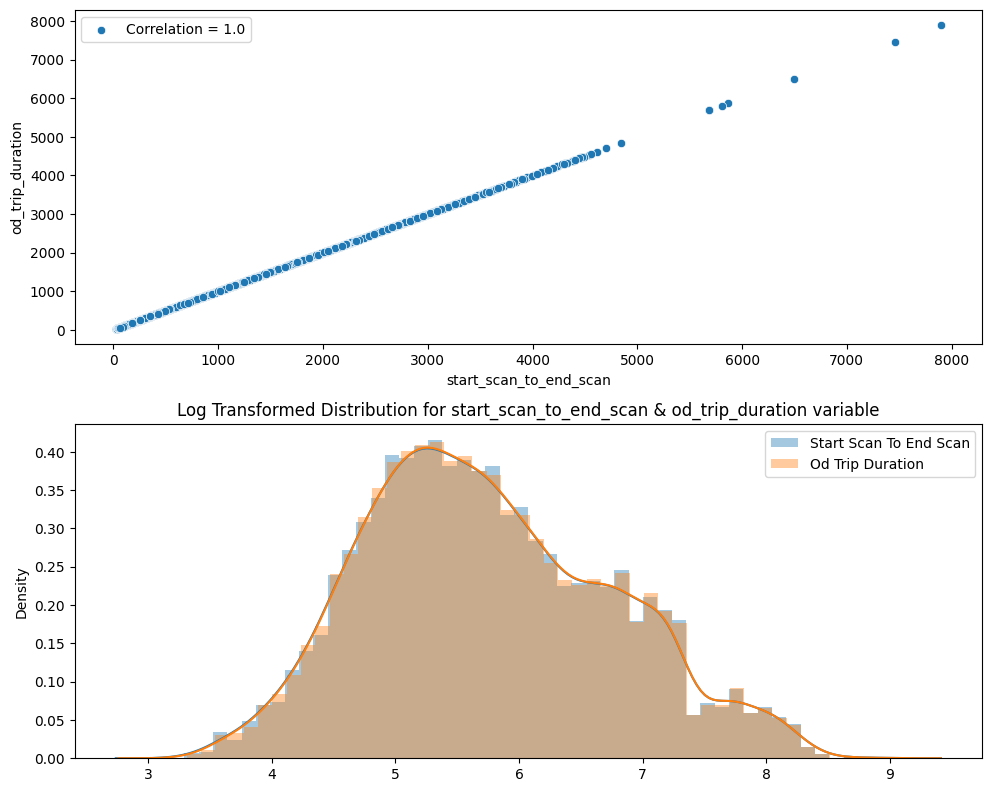

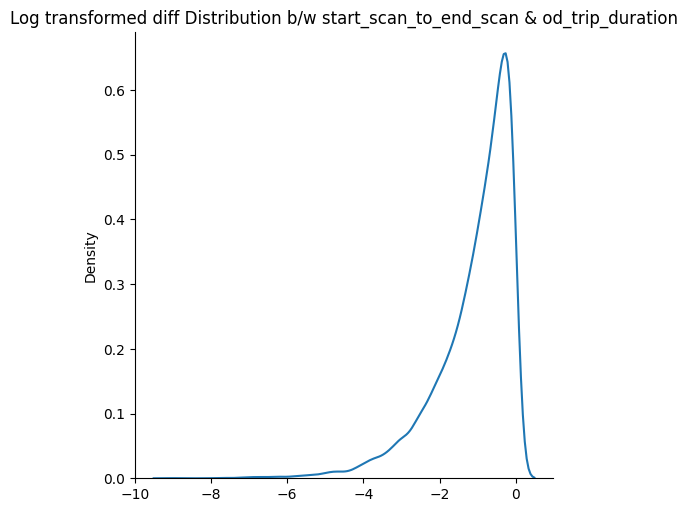

In [27]:
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')

def viz_analysis_nums(x,y, trans_meth = None):
    cor_p, p = stats.pearsonr(trip[x], trip[y])
    cor_p = round(cor_p, 5)
    print("For Correlation Stats Analysis:")
    null_checker(p)

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    sns.scatterplot(data=trip, x=x, y=y, label=f'Correlation = {cor_p}')

    plt.subplot(2, 1, 2)
    x_label = " ".join([i.capitalize() for i in x.split("_")])
    y_label = " ".join([i.capitalize() for i in y.split("_")])
    if trans_meth is None:
        sns.distplot(trip[x], label=x_label)
        sns.distplot(trip[y], label=y_label)
        plt.legend()
        plt.title(f'Distribution for {x} & {y} variable')
    elif trans_meth == 'sqrt':
        sns.distplot(np.sqrt(trip[x]), label=x_label)
        sns.distplot(np.sqrt(trip[y]), label=y_label)
        plt.legend()
        plt.title(f'Sqrt Transformed Distribution for {x} & {y} variable')
    elif trans_meth == 'log':
        sns.distplot(np.log(trip[x]), label=x_label)
        sns.distplot(np.log(trip[y]), label=y_label)
        plt.legend()
        plt.title(f'Log Transformed Distribution for {x} & {y} variable')
    elif trans_meth == 'log1p':
        sns.distplot(np.log1p(trip[x]), label=x_label)
        sns.distplot(np.log1p(trip[y]), label=y_label)
        plt.xlabel('', fontsize=15)
        plt.legend()
        plt.title(f'Log Transformed Distribution for {x} & {y} variable')
    plt.tight_layout(pad=1.0)
    plt.show()

    # plt.figure(figsize=(8, 8))
    if trans_meth is None:
        sns.displot(trip[x]-trip[y], kind='kde', legend=True)
        plt.title(f'Diff Distribution b/w {x} & {y}')
    elif trans_meth == 'sqrt':
        sns.displot(np.sqrt(trip[x]-trip[y]), kind='kde', legend=True)
        plt.title(f'Sqrt transformed diff Distribution b/w {x} & {y}')
    elif trans_meth == 'log':
        sns.displot(np.log(trip[x]-trip[y]), kind='kde', legend=True)
        plt.title(f'Log transformed diff Distribution b/w {x} & {y}')
    elif trans_meth == 'log1p':
        sns.displot(np.log1p(trip[x]-trip[y]), kind='kde', legend=True)
        plt.title(f'Log transformed diff Distribution b/w {x} & {y}')
    else:
        sns.displot(trip[x]-trip[y], kind='kde', legend=True)    
        plt.title(f'Diff Distribution b/w {x} & {y}')
    # plt.tight_layout(pad=1.0)
    plt.show()
viz_analysis_nums(x='start_scan_to_end_scan', y='od_trip_duration', trans_meth = 'log1p')

# start_scan_to_end_scan & od_trip_duration have a very high correlation 
# and seem to be highly collinear/interdependent features.

In [28]:
# H0: means of both the columns are equal
# Ha: means of both the columns are not equal

stat, p = stats.ttest_ind(trip.start_scan_to_end_scan, trip.od_trip_duration)

null_checker(p)
print(stat, p)

# It implies means of both the start_scan_to_end_scan and od_trip_duration are very much at a similar level

Failed to Reject the null hypothesis
-0.11597642119208701 0.9076720147410307


##### OSRM Time v/s Actual Time

For Correlation Stats Analysis:
Reject the null hypothesis


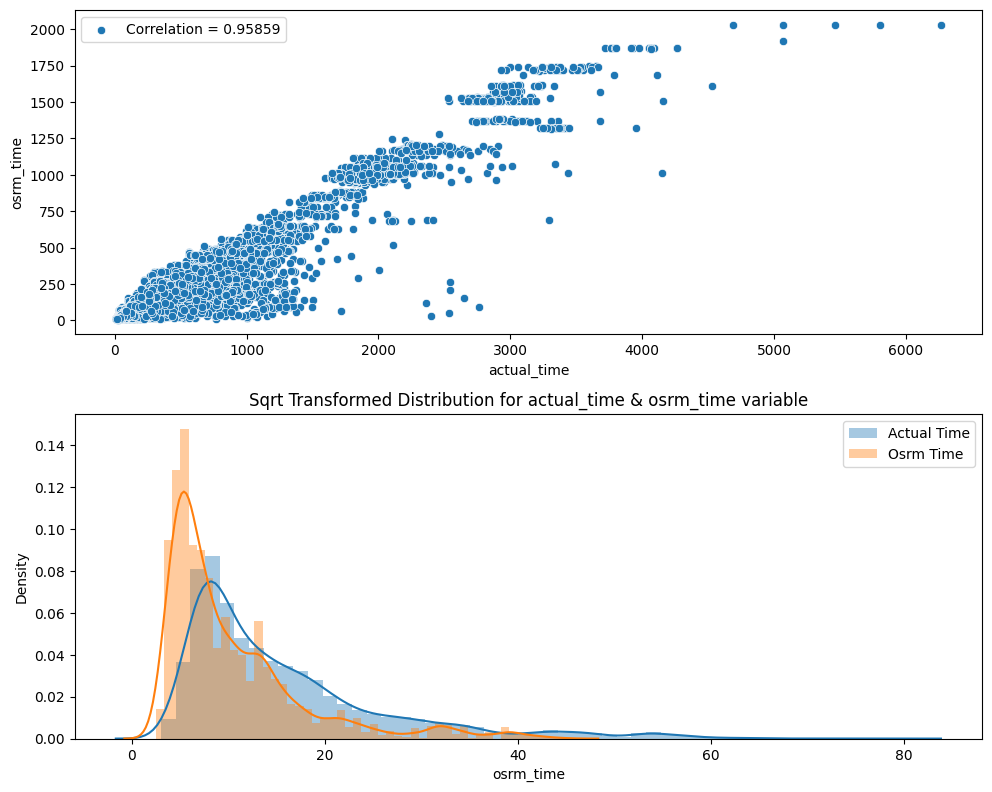

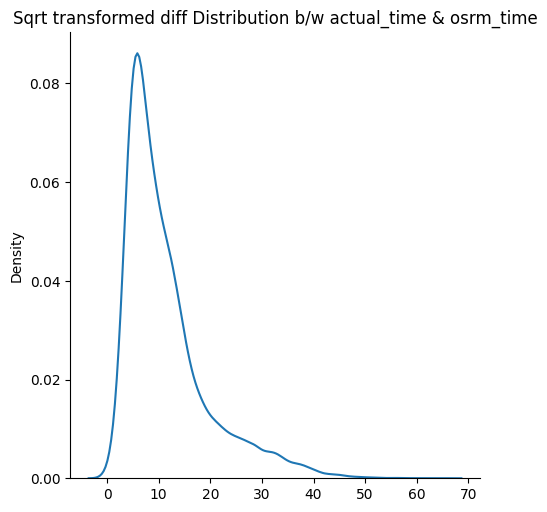

In [29]:
viz_analysis_nums(x='actual_time', y='osrm_time', trans_meth='sqrt')

# It's clear from the graph that osrm_time predicts lesser time 
# than what is actually taken in many cases, following a parabolic 
# looking relation y= mx2 but still need to be verified statistically

# actual_time & osrm_time have a significantly high correlation 
# and seem to be highly collinear/interdependent features 
# but the distributions seem to be quite distinct from each other

In [30]:

# H0: means of both the columns are equal
# Ha: means of both the columns are not equal

stat, p = stats.ttest_ind(trip.actual_time, trip.osrm_time)

null_checker(p)
print(stat, p)

# It implies means of both the actual_time & osrm_time have different means and distributions

Reject the null hypothesis
38.215453905833165 0.0


##### Actual Time v/s Segmented Actual Time

For Correlation Stats Analysis:
Reject the null hypothesis


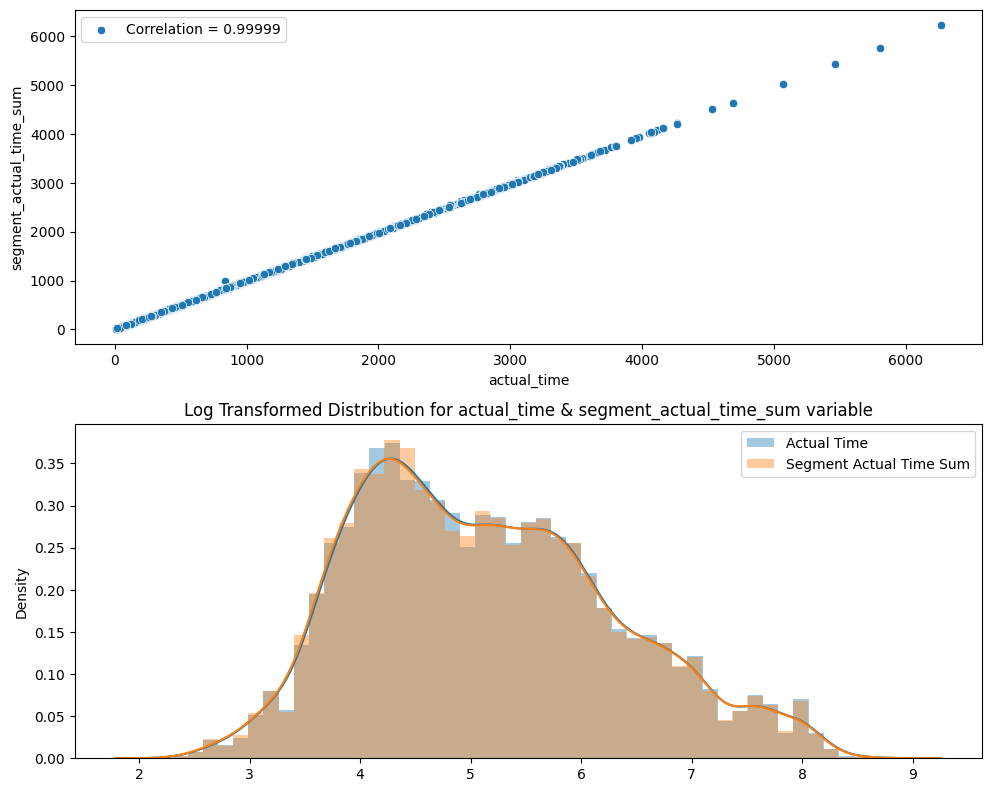

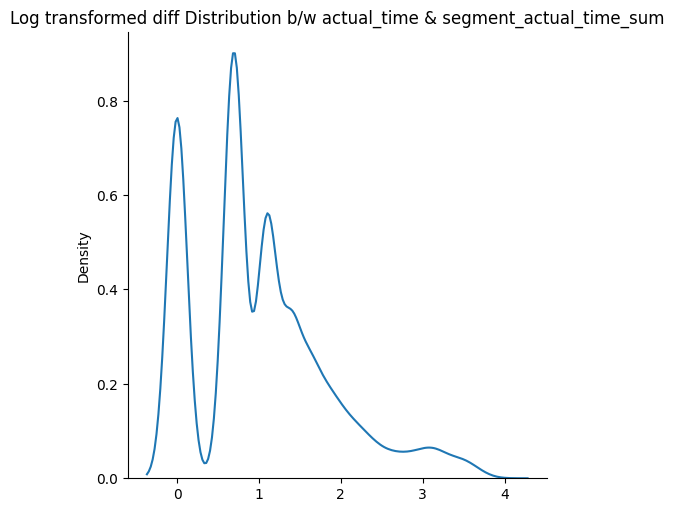

In [31]:
viz_analysis_nums(x='actual_time', y='segment_actual_time_sum', trans_meth = 'log1p')

# actual_time & segment_actual_time_sum have a significantly high correlation 
# and seem to be highly collinear/interdependent features.

In [32]:

# H0: means of both the columns are equal
# Ha: means of both the columns are not equal

stat, p = stats.ttest_ind(trip.actual_time, trip.segment_actual_time_sum)

null_checker(p)
print(stat, p)

# It implies means of both the actual_time & segment_actual_time_sum are very much at a similar level

Failed to Reject the null hypothesis
0.5008024728897531 0.6165138648224772


##### OSRM distance v/s Segment OSRM distance

For Correlation Stats Analysis:
Reject the null hypothesis


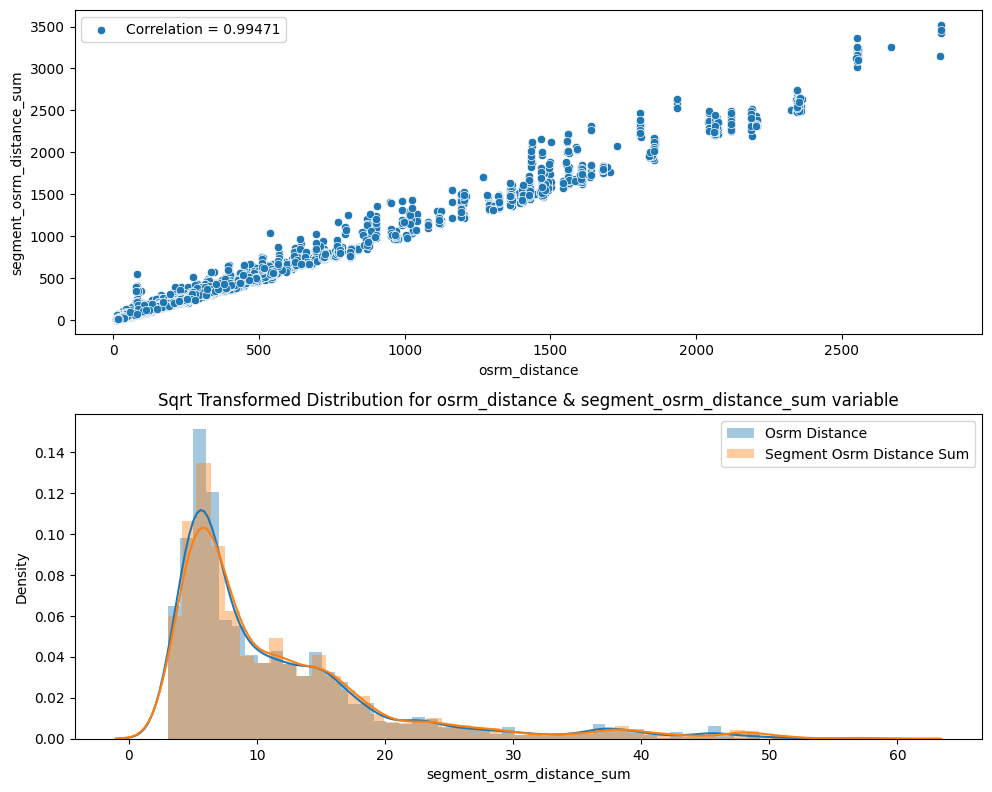

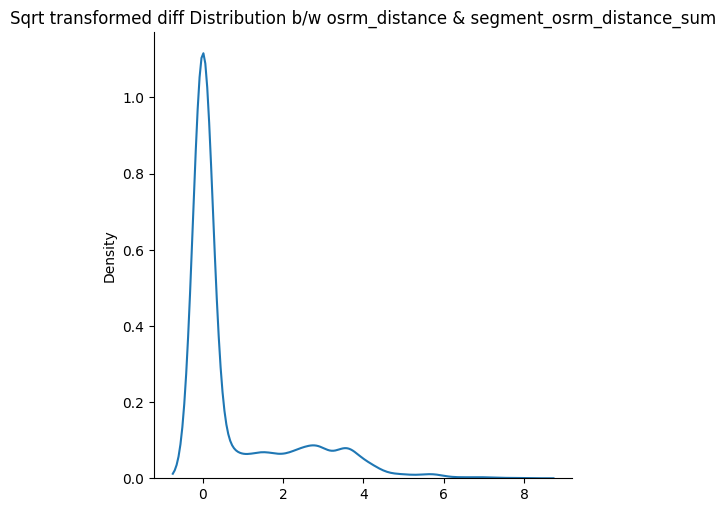

In [33]:
viz_analysis_nums(x='osrm_distance', y='segment_osrm_distance_sum', trans_meth = 'sqrt')

# osrm_distance & segment_osrm_distance_sum have a very high correlation 
# and seem to be highly collinear/interdependent features

In [34]:

# H0: means of both the columns are equal
# Ha: means of both the columns are not equal

stat, p = stats.ttest_ind(trip.osrm_distance, trip.segment_osrm_distance_sum)

null_checker(p)
print(stat, p)

# It implies means of both the osrm_distance & segment_osrm_distance_sum are not significantly equal.
# It implies that the even though osrm_distance and segment_osrm_distance enjoy a very high correlation 
# but still the two variables are somewhat different from each other. 

Reject the null hypothesis
-4.117367046483823 3.842631473353718e-05


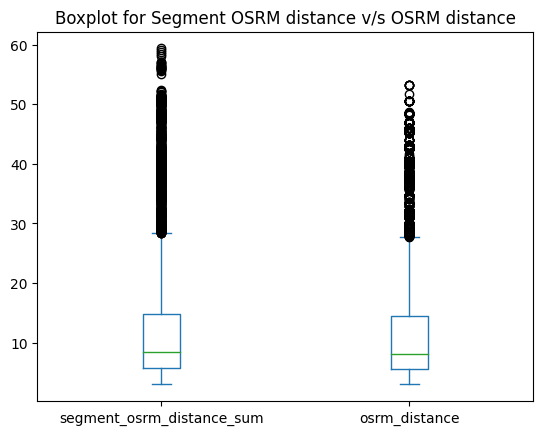

In [35]:

np.sqrt(trip[['segment_osrm_distance_sum', 'osrm_distance']]).plot(kind='box', title=f'Boxplot for Segment OSRM distance v/s OSRM distance')
plt.show()
# Upon comparing the distributions, there seem to be some inherent differences in the two means 
# but the distributions are almost the same, 
# it just that segmented OSRM distance has a few higher outliers than OSRM distance. 
# This invites outlier treatment via IQR method, which will help reduce the impact of very high outliers on the overall analysis


##### OSRM Time v/s Segmented OSRM time

For Correlation Stats Analysis:
Reject the null hypothesis


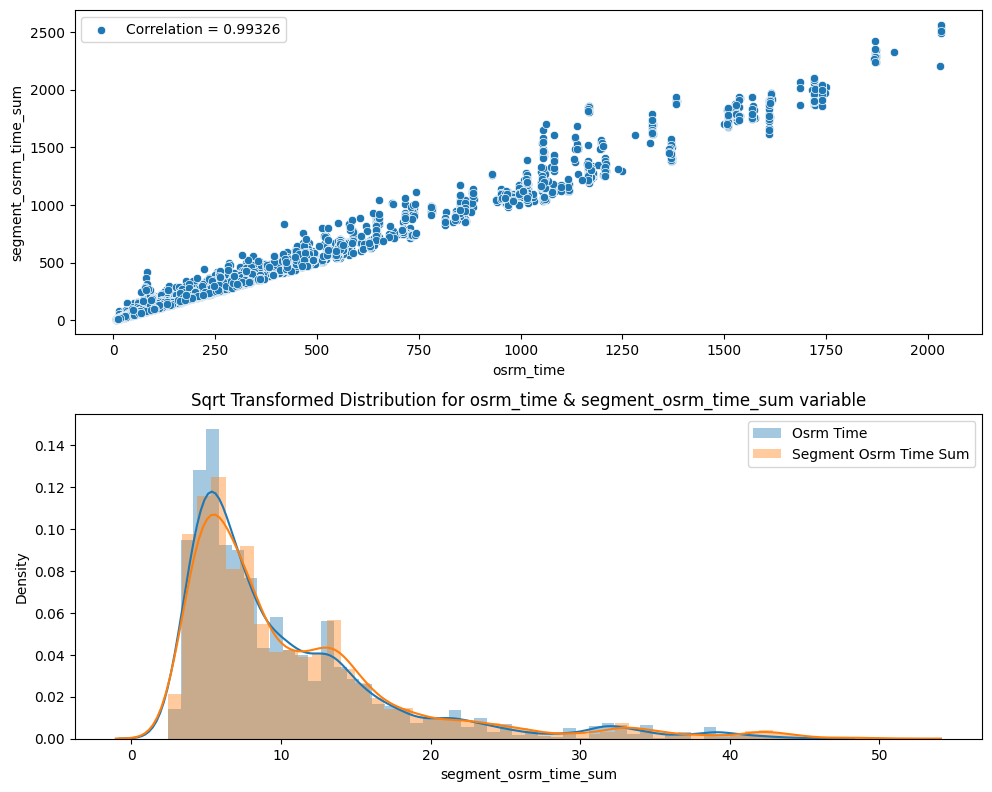

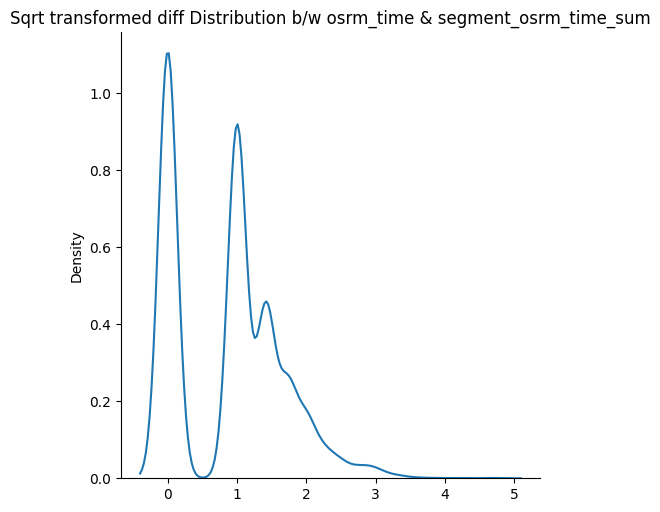

In [36]:
viz_analysis_nums(x='osrm_time', y='segment_osrm_time_sum', trans_meth = 'sqrt')

# osrm_time & segment_osrm_time_sum have a very high correlation 
# and seem to be highly collinear/interdependent features

In [37]:

# H0: means of both the columns are equal
# Ha: means of both the columns are not equal

stat, p = stats.ttest_ind(trip.osrm_time, trip.segment_osrm_time_sum)

null_checker(p)
print(stat, p)

# It implies means of both the osrm_time & segment_osrm_time_sum are not significantly equal.
# It implies that the even though osrm_time and segment_osrm_time enjoy a very high correlation 
# but still the two variables are somewhat different from each other. 

Reject the null hypothesis
-5.733106696963521 9.956426798219171e-09


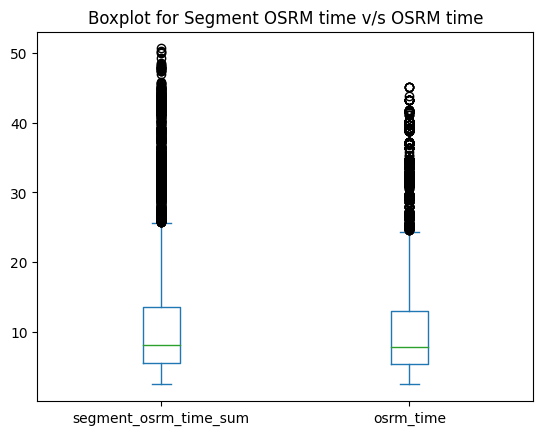

In [38]:

np.sqrt(trip[['segment_osrm_time_sum', 'osrm_time']]).plot(kind='box', title=f'Boxplot for Segment OSRM time v/s OSRM time')
plt.show()
# Upon comparing the distributions, there seem to be some inherent differences in the two means 
# but the distributions are almost the same, 
# it just that segmented OSRM time has a few higher outliers than OSRM time. 
# This invites outlier treatment via IQR method, which will help reduce the impact of very high outliers on the overall analysis


In [39]:
trip['source_name']

0         kanpur_central_h_6 (uttar pradesh)
1          doddablpur_chikadpp_d (karnataka)
2              gurgaon_bilaspur_hb (haryana)
3                   mumbai hub (maharashtra)
4                     bellary_dc (karnataka)
                        ...                 
14812         chandigarh_mehmdpur_h (punjab)
14813           fbd_balabhgarh_dpc (haryana)
14814     kanpur_govndngr_dc (uttar pradesh)
14815    tirunelveli_vdkkusrt_i (tamil nadu)
14816          sandur_wrdn1dpp_d (karnataka)
Name: source_name, Length: 14817, dtype: object

In [40]:
segment['destination_name'].unique()

array(['Gurgaon_Bilaspur_HB (Haryana)',
       'Kanpur_Central_H_6 (Uttar Pradesh)',
       'Chikblapur_ShntiSgr_D (Karnataka)', ...,
       'Kapadvanj_Busstand_D (Gujarat)', 'Lunawada_VrdhriRD_D (Gujarat)',
       'Jaipur_Central_D_1 (Rajasthan)'], dtype=object)

In [41]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14817 entries, 0 to 14816
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   data                            14817 non-null  object        
 1   trip_creation_time              14817 non-null  datetime64[ns]
 2   route_schedule_uuid             14817 non-null  object        
 3   route_type                      14817 non-null  object        
 4   trip_uuid                       14817 non-null  object        
 5   source_center                   14817 non-null  object        
 6   source_name                     14807 non-null  object        
 7   destination_center              14817 non-null  object        
 8   destination_name                14809 non-null  object        
 9   start_scan_to_end_scan          14817 non-null  float64       
 10  od_trip_duration                14817 non-null  float64       
 11  ac